In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
import json

In [14]:
df = pd.read_csv("data/og_train.csv")
df.secondary_type = df.secondary_type.fillna("None")
df["path"] = "data/train/" + df.image_id + ".png" 
df["ds_type"] = "og"
df.head()

,image_id,main_type,secondary_type,path,ds_type
0,aae8b80f-e334-4974-a3c6-5e922fb76284,Bug,Grass,data/train/aae8b80f-e334-4974-a3c6-5e922fb7628...,og
1,cd792a8c-717b-4a60-85ee-7940ce0f81bb,Water,None,data/train/cd792a8c-717b-4a60-85ee-7940ce0f81b...,og
2,b2206a6a-d898-4c01-9b0f-6775a2b302a8,Electric,None,data/train/b2206a6a-d898-4c01-9b0f-6775a2b302a...,og
3,6f6d6294-93da-410a-801a-29dbe353b148,Fairy,None,data/train/6f6d6294-93da-410a-801a-29dbe353b14...,og
4,7ae5d5d4-650b-40c9-bebb-7153f45f793c,Electric,Fairy,data/train/7ae5d5d4-650b-40c9-bebb-7153f45f793...,og


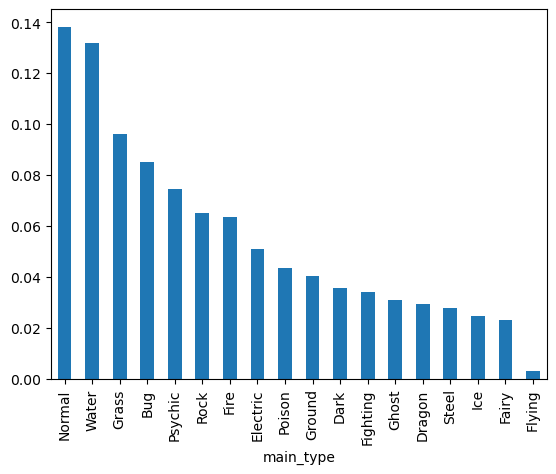

In [15]:
df.value_counts("main_type", normalize=True).plot.bar()
plt.show()

In [16]:
test_images = pd.DataFrame({"path": glob("data/test/*.png")})
test_images["ds_type"] = "test"
test_images["image_id"] = test_images.path.apply(lambda x: os.path.basename(x).replace(".png",""))

df = pd.concat((df, test_images))

In [17]:
add_data = pd.read_csv("data/generated_imgs.csv", index_col=0).reset_index(names = "pokemon")

add_data  = add_data.rename(columns = {
    "primary":"main_type",
    "Id": "image_id",
})[["image_id","main_type", "background_path","pokemon"]]
add_data["path"] = "data/generated/" + add_data.image_id.astype(str) + ".jpg"
add_data["ds_type"] = "aug"

labels = set(add_data.main_type.unique())
og = set(df.main_type)
og.discard(np.nan)
assert labels == og

df = pd.concat((df.sample(frac=1, random_state=0), add_data.sample(frac=1, random_state=0)))
df.index = np.arange(len(df))

In [18]:


def crop_path(path:str):
    
    base, ending = os.path.split(path)
    
    return os.path.join(base + "_cropped", ending)

df["cropped_path"] = df.path.apply(crop_path)
df["cropp_exists"] = df.cropped_path.apply(os.path.exists)
to_drop = df.query("ds_type == 'aug' and not cropp_exists").index
df = df.drop(index=to_drop)
df.groupby("ds_type").cropp_exists.mean()

ds_type
aug     1.000000
og      0.976553
test    0.983030
Name: cropp_exists, dtype: float64

In [19]:
classes = sorted(df.main_type.dropna().unique())

class2id = {b:a for a,b in enumerate(classes)}
id2class = {a:b for a,b in enumerate(classes)}

with open("data/class2id.json", "w") as f:
    json.dump(class2id, f)
    
with open("data/id2class.json", "w") as f:
    json.dump(id2class, f)

class2id[np.nan] = None


df["class_id"] = df.main_type.map(class2id)
to_counts = df.class_id.value_counts().to_dict()
df["class_counts"] = df.class_id.map(to_counts)
df.class_counts


0         6469.0
1         6149.0
2         5644.0
3         6469.0
4         5649.0
           ...  
108085    5656.0
108086    5649.0
108087    5649.0
108088    5778.0
108089    6469.0
Name: class_counts, Length: 107500, dtype: float64

In [21]:
pokemon_classes = sorted(df.pokemon.dropna().unique())
class2id = {b:a for a,b in enumerate(classes)}
df["poke_id"] = df.pokemon.map(class2id)

In [22]:
df.to_csv("data/info.csv")